# SLC inhibitor predictions

We compare a list of SLC inhibitors from the GSF lab with a background set from ChEMBL

(10140, 92)


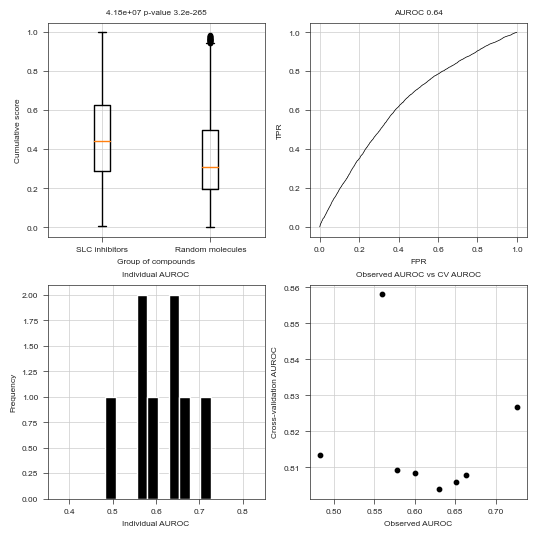

In [16]:
import pandas as pd
import joblib
import stylia
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import RobustScaler

MIN_AUROC = 0.8
MAX_MW = 600
MIN_MW = 150

df_bg = pd.read_csv("../results/1_chembl_predictions_0.tsv", sep="\t")
df_in = pd.read_csv("../results/1_gsf_predictions.tsv", sep="\t")

df_in = df_in[df_in["mw"] < MAX_MW]
df_bg = df_bg[df_bg["mw"] < MAX_MW]
df_in = df_in[df_in["mw"] > MIN_MW]
df_bg = df_bg[df_bg["mw"] > MIN_MW]

print(df_in.shape)

protein_precalcs = joblib.load("../data/protein_precalcs.joblib")
protein_aucs = {}
for d in protein_precalcs:
    protein_aucs[d["uniprot_ac"]] = d["auroc"]

slc_columns = []
for slc in list(df_bg.columns):
    if slc not in protein_aucs:
        continue
    auroc = protein_aucs[slc][0]
    if auroc is None:
        auroc = 0
    if auroc >= MIN_AUROC:
        slc_columns += [slc]

X_in = np.array(df_in[slc_columns])
X_bg = np.array(df_bg[slc_columns])

#scaler = RobustScaler()
#scaler.fit(np.vstack([X_in, X_bg]))
#X_in = scaler.transform(X_in)
#X_bg = scaler.transform(X_bg)
#vals_in = np.percentile(X_in, 50, axis=1)
#vals_bg = np.percentile(X_bg, 50, axis=1)
vals_in = np.percentile(X_in, 75, axis=1)
vals_bg = np.percentile(X_bg, 75, axis=1)

fig, axs = stylia.create_figure(2,2,width=stylia.TWO_COLUMNS_WIDTH*0.75, height=stylia.TWO_COLUMNS_WIDTH*0.75)
ax = axs.next()

ax.boxplot([vals_in, vals_bg], flierprops=dict(marker='o', markersize=3))
ax.set_xticklabels(["SLC inhibitors", "Random molecules"])
u_statistic, p_value = mannwhitneyu(vals_bg, vals_in)
stylia.label(ax=ax, title="{0:.3g} p-value {1:.2g}".format(u_statistic, p_value), xlabel="Group of compounds", ylabel="Cumulative score")

ax = axs.next()
fpr, tpr, _ = roc_curve([1]*len(vals_in) + [0]*len(vals_bg), list(vals_in) + list(vals_bg))
ax.plot(fpr, tpr, color="black")
stylia.label(ax=ax, title="AUROC {0:.2f}".format(auc(fpr, tpr)), xlabel="FPR", ylabel="TPR")

ax = axs.next()
aurocs = []
for i in range(X_in.shape[1]):
    v1 = X_in[:, i]
    v0 = X_bg[:, i]
    fpr, tpr, _ = roc_curve([1]*len(v1) + [0]*len(v0), list(v1) + list(v0))
    aurocs += [auc(fpr, tpr)]
ax.hist(aurocs, bins=10, color="black")
ax.set_xlim(0.35, 0.85)
ax.plot([0,0], [1,1], color="black", linestyle="--")
stylia.label(ax=ax, title="Individual AUROC", xlabel="Individual AUROC", ylabel="Frequency")

ax = axs.next()
cv_aurocs = [protein_aucs[slc][0] for slc in slc_columns]

ax.scatter(aurocs, cv_aurocs, color="black")
stylia.label(ax=ax, title="Observed AUROC vs CV AUROC", xlabel="Observed AUROC", ylabel="Cross-validation AUROC")

stylia.save_figure("../assets/gsf_validation_exploratory.png")